In [405]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
import random
import seaborn as sns
import scipy
import statsmodels.api as sm
import warnings
from sklearn.metrics import mean_squared_error


from pmdarima.arima import auto_arima
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess


In [406]:
df = pd.read_excel("../Series/TRM.xlsx", index_col = 'Fecha', parse_dates= True)

In [407]:
# Resample to monthly frequency, aggregating with mean
df = df.resample('M').mean()

In [408]:
# Create a new column in the df that contains the log returns of the TRM *100
df['log_ret'] = (np.log(df['TRM']) - np.log(df['TRM'].shift(1))) * 100


In [409]:
avg_returns = df.log_ret.mean()
avg_returns

0.5403410052212074

In [410]:
df['sq_dem_ret_2'] = (df.log_ret - avg_returns)**2

In [411]:
df = df.dropna()

In [412]:
############ MEJOR MODELO

from itertools import product

p = [1,2,3,4,5,6,7,8,9,10,11,12]
q = [1,2,3,4,5,6,7,8,9,10,11,12]

scores = pd.DataFrame(product(*[p,q]), columns = ["p", "q"]) 

## 1. Initial ARIMA model estimation

In [ ]:
for p in range(0,13): 
    for q in (range(0,13)): 
        model = ARIMA(df.sq_dem_ret_2,  order=(p, 0, q)).fit() 
        scores.loc[ (scores.p == p) & (scores.q == q), "AIC"] = round(model.aic, 2) #cuando la columna p y q sean p y q (del loop) rellenar el AIC con el del modelo
        scores.loc[ (scores.p == p) & (scores.q == q), "BIC"] = round(model.bic, 2)

In [ ]:
scores

,p,q,AIC,BIC
0,1,1,3169.15,3184.86
1,1,2,3171.15,3190.78
2,1,3,3171.40,3194.96
3,1,4,3171.93,3199.42
4,1,5,3173.93,3205.35
...,...,...,...,...
139,12,8,3177.39,3263.78
140,12,9,3178.47,3268.79
141,12,10,3179.90,3274.14
142,12,11,3182.24,3280.41


In [ ]:
scores.sort_values("AIC")

,p,q,AIC,BIC
26,3,3,3166.61,3198.02
109,10,2,3166.63,3221.61
73,7,2,3167.37,3210.57
38,4,3,3167.48,3202.83
27,3,4,3167.57,3202.91
...,...,...,...,...
117,10,10,3182.42,3268.81
118,10,11,3183.37,3273.69
119,10,12,3183.93,3278.17
131,11,12,3186.34,3284.52


We have two possible models: using the AIC it's an ARMA (3,3) and using BIC it's an ARMA (1,1)

In [ ]:
final_ARMA = ARIMA(df.sq_dem_ret_2, order=(1, 0, 1)).fit()

In [ ]:
print(final_ARMA.summary())

                               SARIMAX Results                                
Dep. Variable:           sq_dem_ret_2   No. Observations:                  375
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1580.575
Date:                Sun, 23 Apr 2023   AIC                           3169.150
Time:                        18:51:14   BIC                           3184.858
Sample:                    01-31-1992   HQIC                          3175.386
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1531      4.034      2.021      0.043       0.246      16.060
ar.L1          0.9196      0.051     17.985      0.000       0.819       1.020
ma.L1         -0.8217      0.071    -11.594      0.0

In [ ]:
resids = final_ARMA.resid

In [ ]:
sq_resid = resids **2

/opt/anaconda3/envs/universidad/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/anaconda3/envs/universidad/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


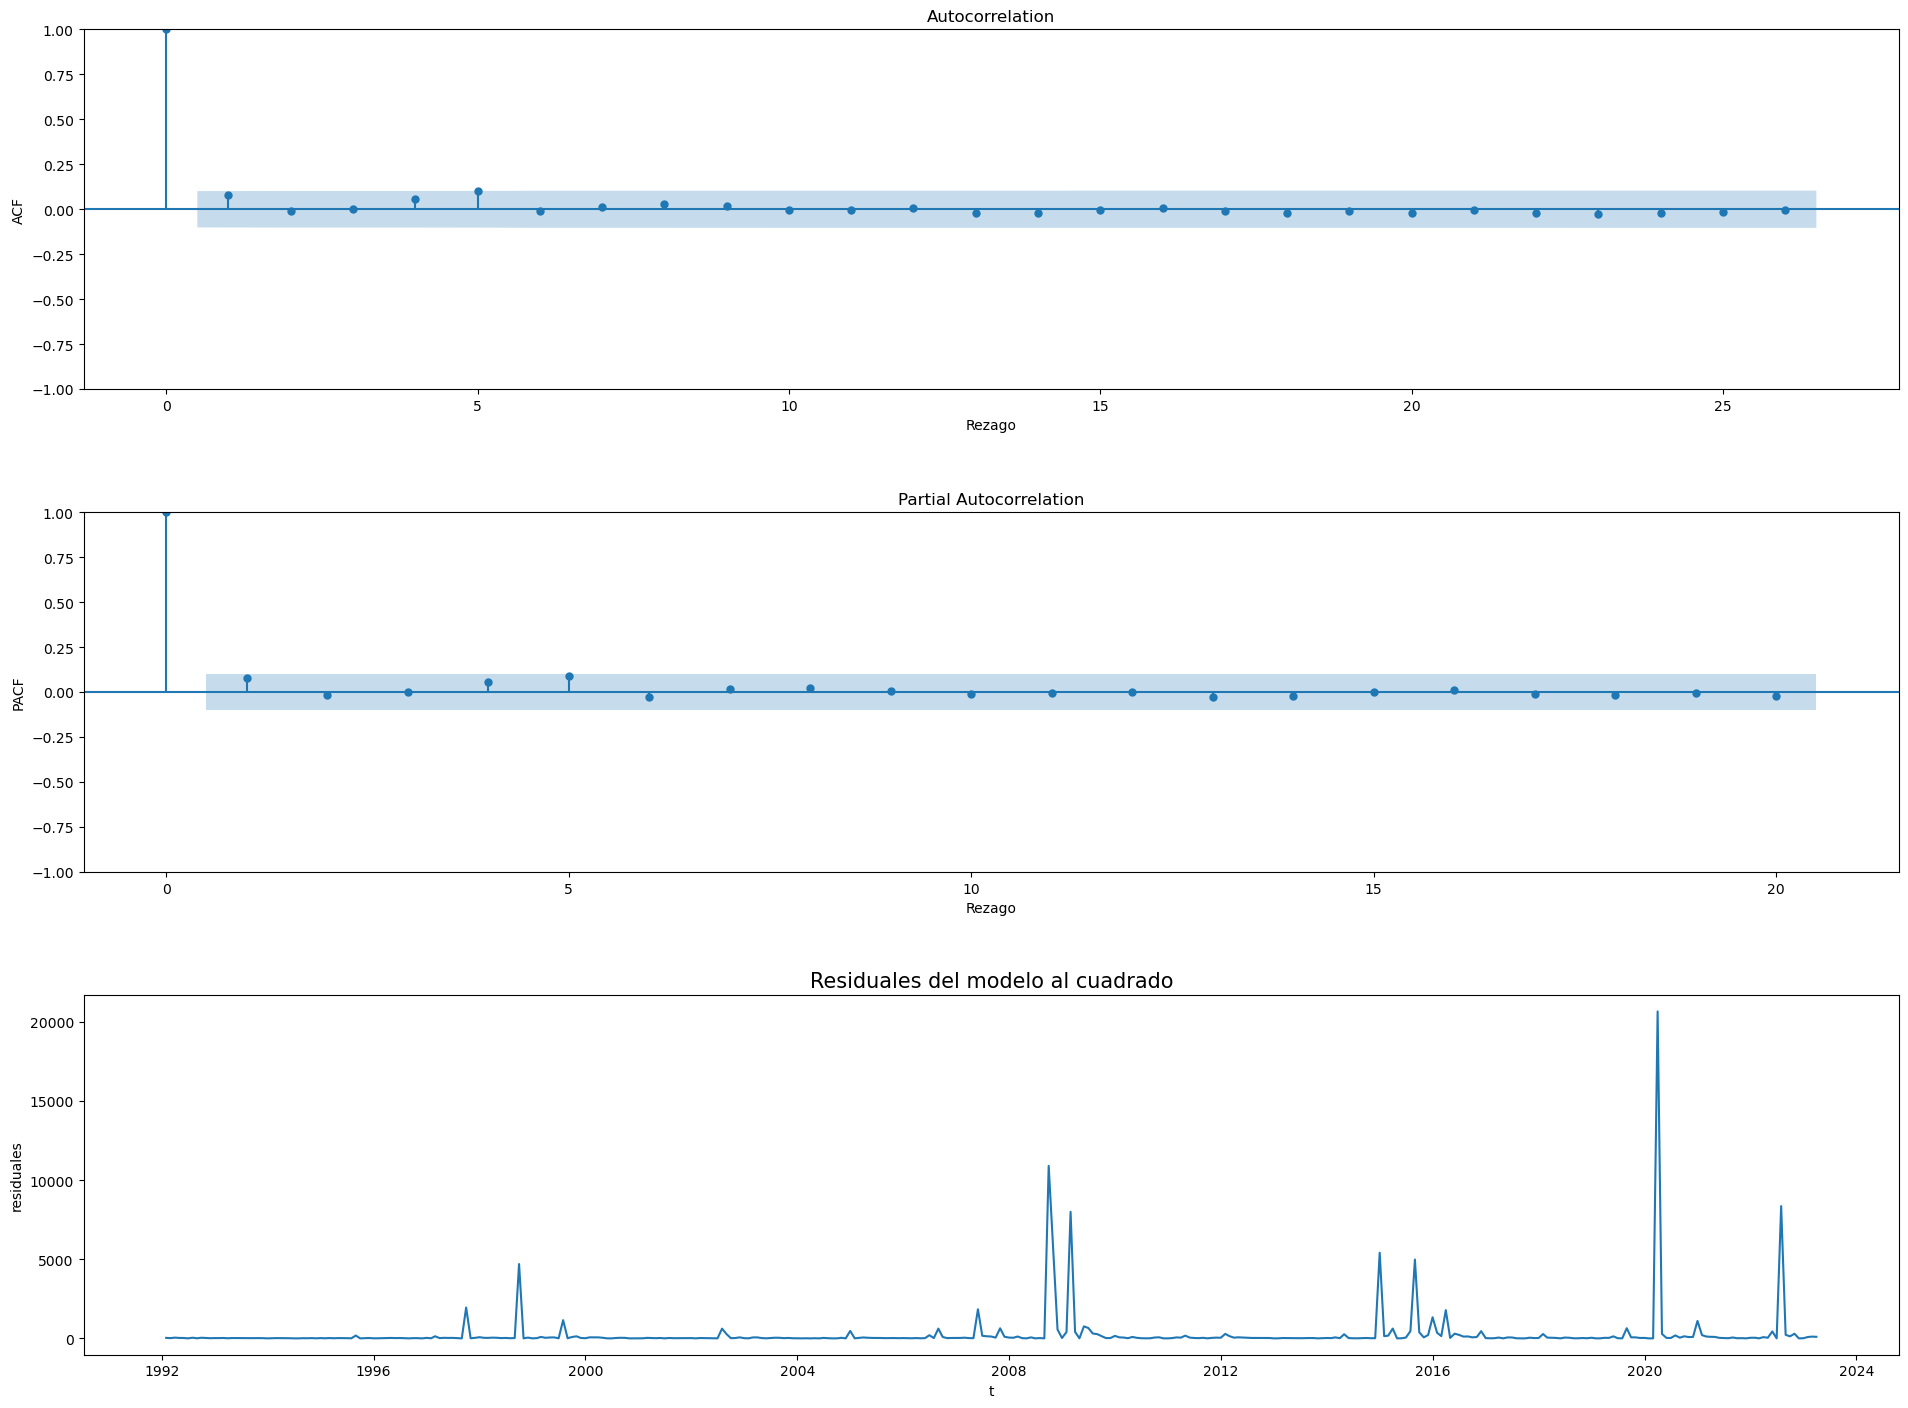

In [ ]:
fig, ax =plt.subplots(3,1, figsize=(20, 15), sharex = False)
plot_acf(sq_resid, ax = ax[0], alpha = 0.05)
ax[0].set_xlabel('Rezago', fontsize=10)
ax[0].set_ylabel('ACF', fontsize=10)

plot_pacf(sq_resid, ax = ax[1], lags  = 20, alpha = 0.05, method = "ols")
ax[1].set_xlabel('Rezago', fontsize=10)
ax[1].set_ylabel('PACF', fontsize=10)

sns.lineplot(y = sq_resid, x = sq_resid.index, dashes= True, err_style ="bars", ax = ax[2])
ax[2].set_xlabel('t', fontsize=10)
ax[2].set_ylabel('residuales', fontsize=10)
ax[2].set_title('Residuales del modelo al cuadrado', fontsize = 15)


fig.tight_layout(pad=4.0)

In [ ]:
lb_test = sm.stats.acorr_ljungbox(sq_resid, lags=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], return_df=True)

In [ ]:
lb_test

,lb_stat,lb_pvalue
1,2.270566,0.131852
2,2.314720,0.314315
3,2.315064,0.509641
4,3.498636,0.478086
5,7.267221,0.201513
6,7.318781,0.292370
7,7.395588,0.388885
8,7.693273,0.463991
9,7.861515,0.548160
10,7.862312,0.642284


It can be noted that the residuals are behaving normally, meaning we wont have to model the variance using an ARCH or GARCH model/

## 2. One step ahead forecast using all possible information
Instead of doing a rolling window, where the data available remains constant through time, we'll implement an increasing size window, which for the first forecast contains 276 data points (the amount of months between 1992 and 2014), and for the second forecast contains 277 data ponts (the same as before plus the month of january, 2015).

In [ ]:
len_indexes_to_predict = df['2015':'2023'].shape[0] 
len_history = df['1992': '2014'].shape[0] - 1

In [ ]:
actual_values = []
predicted_values = []
for i in range(len_indexes_to_predict):
    actual_values.append(df.sq_dem_ret_2[len_history + i + 1])
    available_data = df.sq_dem_ret_2[0:len_history + i + 1]
    model = ARIMA(available_data, order=(1, 0, 1)).fit()
    predicted_values.append(model.forecast(1)[0])


## 3. One step ahead density forecast using all possible information


Given that we didn't have to model the variance, we'll get densities using a MonteCarlo simulation sampling errors from a normal distribution where the variance is that of the model.

In [ ]:
density_forecasts = []
for i in range(len_indexes_to_predict):
    available_data = df.sq_dem_ret_2[0:len_history + i + 1]
    model = ARIMA(available_data, order=(1, 0, 1)).fit()
    sampled_errors = np.random.normal(0, np.std(model.resid), 1000)
    density_forecasts.append(model.forecast(1)[0] + sampled_errors)

In [462]:
def create_fanchart(result, forecast, actual_values):
    x = np.arange(result.shape[0])
    # for the median use `np.median` and change the legend below
    mean = forecast  #np.mean(result, axis=1)
    offsets = (10,20,30,40)
    fig, ax = plt.subplots()
    ax.plot(mean, color='black', lw=0.5)
    ax.plot(actual_values, color='red', lw=0.5)
    for offset in offsets:
        low = np.percentile(result, 50-offset, axis=1)
        high = np.percentile(result, 50+offset, axis=1)
        # since `offset` will never be bigger than 50, do 55-offset so that
        # even for the whole range of the graph the fanchart is visible
        alpha = (50 - offset) / 100
        ax.fill_between(x, low, high, color='blue', alpha=alpha)
    ax.legend(['Predicción'] + ['Y'] +  [f'Pct{2*o}' for o in offsets])
    ax.set_xlabel('Tiempo')
    ax.set_ylabel('Valor')
    ax.set_title('Fanchart de la predicción de densidad')
    return fig, ax


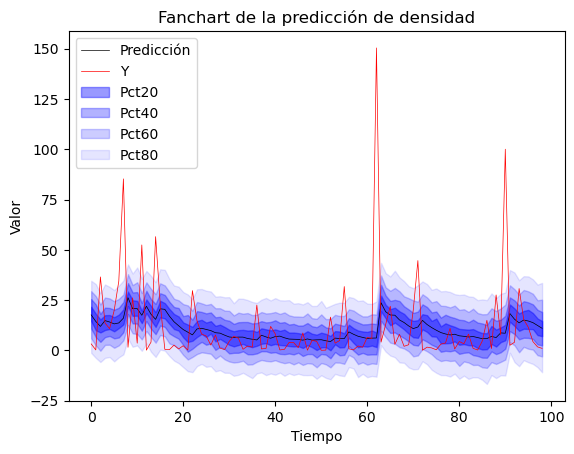

In [463]:
fig, ax = create_fanchart(np.array(density_forecasts), predicted_values, actual_values)
plt.show()

## 4. Random walk model

For this point we'll suppose the time series behaves like a random walk without trend. This is basically an AR(1) process.

In [ ]:
random_walk_predicted_values = []
for i in range(len_indexes_to_predict):
    available_data = df.sq_dem_ret_2[0:len_history + i + 1]
    model = ARIMA(available_data, order=(1, 0, 0)).fit()
    random_walk_predicted_values.append(model.forecast(1)[0])

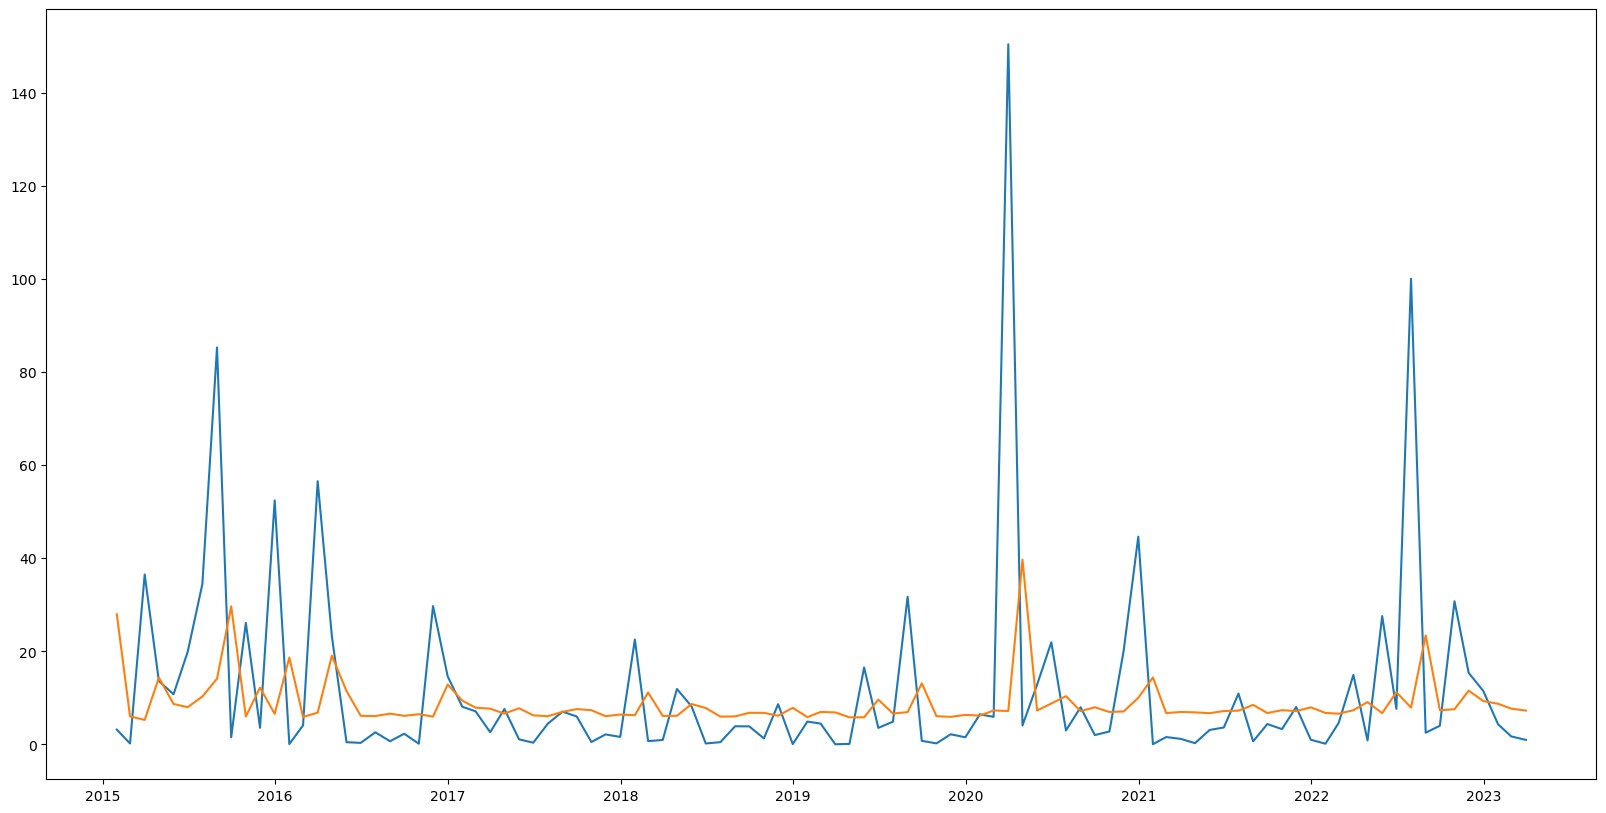

In [ ]:
# Plot random walk predictions and actual values
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df.index[len_history +1 :], df.sq_dem_ret_2[len_history +1 :], label='Actual')
ax.plot(df.index[len_history +1 :], random_walk_predicted_values, label='Random Walk')

In [ ]:
random_walk_density_forecasts = []
for i in range(len_indexes_to_predict):
    available_data = df.sq_dem_ret_2[0:len_history + i + 1]
    model = ARIMA(available_data, order=(1, 0, 0)).fit()
    sampled_errors = np.random.normal(0, np.std(model.resid), 1000)
    random_walk_density_forecasts.append(model.forecast(1)[0] + sampled_errors)

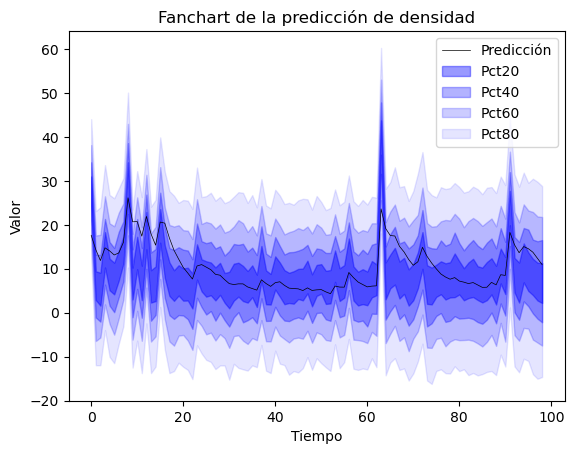

In [ ]:
fig, ax = create_fanchart(np.array(random_walk_density_forecasts), predicted_values)#, actual_values)
plt.show()

# B. Point forecast evaluation

In [ ]:
resids_df = pd.DataFrame({'Fecha': df['2015':'2023'].index, 'resids': np.array(actual_values) - np.array(predicted_values)})

/opt/anaconda3/envs/universidad/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/anaconda3/envs/universidad/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/opt/anaconda3/envs/universidad/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/anaconda3/envs/universidad/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0, 0.5, 'PACF')

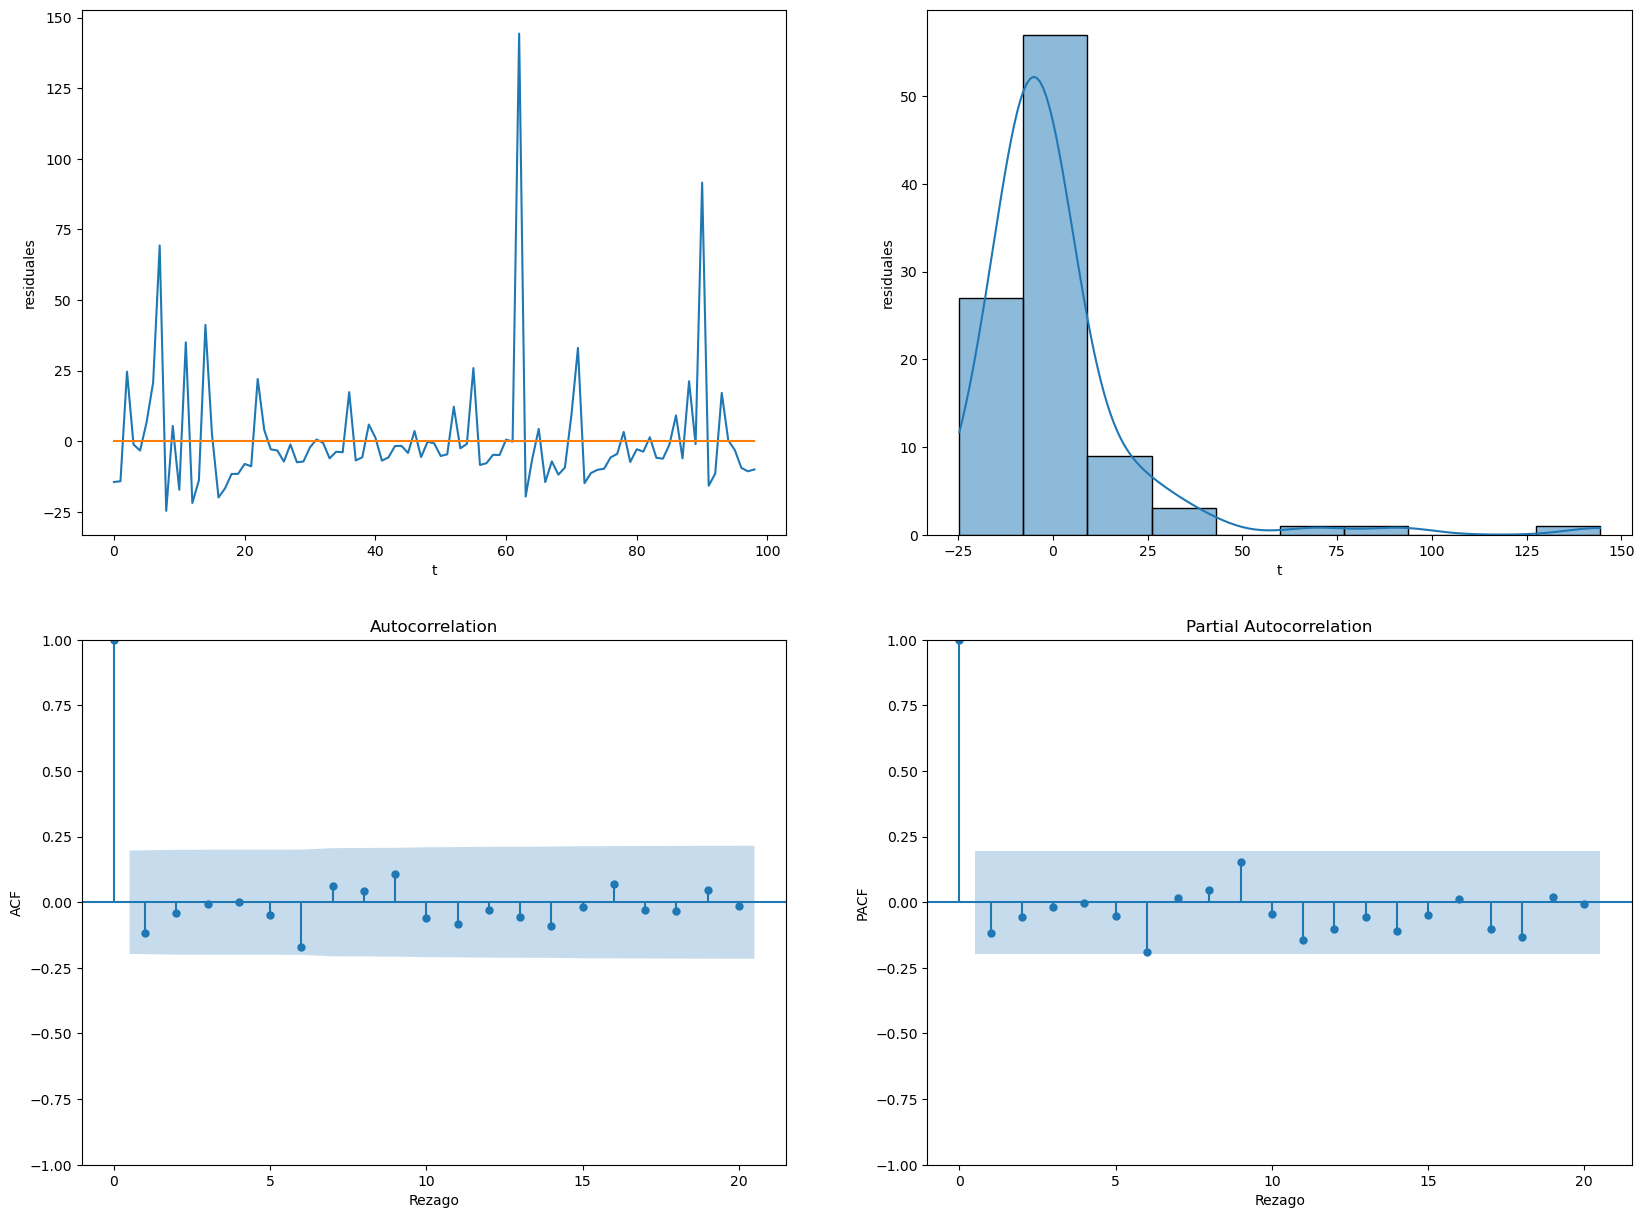

In [ ]:
fig, ax =plt.subplots(2,2, figsize=(20, 15), sharex = False)

sns.lineplot(y = resids_df.resids, x = resids_df.index, dashes= True, err_style ="bars", ax = ax[0, 0])
sns.lineplot(y = np.zeros(len(resids)),  x = resids_df.index, dashes= True, err_style ="bars", ax = ax[0, 0])
ax[0,0].set_xlabel('t', fontsize=10)
ax[0,0].set_ylabel('residuales', fontsize=10)


sns.histplot(x = resids_df.resids , ax=ax[0,1], bins = 10, kde = True)
ax[0,1].set_xlabel('t', fontsize=10)
ax[0,1].set_ylabel('residuales', fontsize=10)


#FIG 1
plot_acf(resids_df.resids, ax = ax[1,0], alpha = 0.05)
ax[1,0].set_xlabel('Rezago', fontsize=10)
ax[1,0].set_ylabel('ACF', fontsize=10)

#FIG 2
plot_pacf(resids_df.resids, ax = ax[1,1], lags  = 20, alpha = 0.05, method = "ols")
ax[1,1].set_xlabel('Rezago', fontsize=10)
ax[1,1].set_ylabel('PACF', fontsize=10)

#fig.savefig('./plots/resid_analysis2,2,2,b.png')

Looks normal, right?

#### Mincer Zarnowitz Regression

In [ ]:
# Do a linear regression where Y are the actual values and X are the predicted values
X = sm.add_constant(predicted_values)
model = sm.OLS(actual_values, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.2726
Date:                Sun, 23 Apr 2023   Prob (F-statistic):              0.603
Time:                        20:37:14   Log-Likelihood:                -444.79
No. Observations:                  99   AIC:                             893.6
Df Residuals:                      97   BIC:                             898.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.2296      5.084      1.815      0.0

This results seem to determine that our forecast is not optimal. In particular, this  results imply that some of the available information might be better used to improve our forecast, therefore, our errors are not orthogonal to the information

In [ ]:
resids_df.rename(columns={'resids': 'model_resids'}, inplace=True)

In [ ]:
resids_df['random_walk_resids'] = np.array(actual_values) - np.array(random_walk_predicted_values)

In [ ]:
resids_df['model_resids_sq'] = resids_df.model_resids**2
resids_df['random_walk_resids_sq'] = resids_df.random_walk_resids**2


In [ ]:
MSE1 = np.mean(resids_df.model_resids_sq)
MSE2 = np.mean(resids_df.random_walk_resids_sq)
RMSE1 = np.sqrt(MSE1)
RMSE2 = np.sqrt(MSE2)
MAE1 = np.mean(np.abs(resids_df.model_resids))
MAE2 = np.mean(np.abs(resids_df.random_walk_resids))
R2_1 = 1 - MSE1/np.sum((actual_values - np.mean(actual_values))**2)
R2_2 = 1 - MSE2/np.sum((actual_values - np.mean(actual_values))**2)
naive_forecast = df.sq_dem_ret_2.shift()
rmse_naive = np.sqrt(mean_squared_error(df.sq_dem_ret_2[1:], naive_forecast.dropna()))
Theil1 = RMSE1/rmse_naive
Theil2 = RMSE2/rmse_naive
pd.DataFrame({'MSE': [MSE1, MSE2], 'RMSE': [RMSE1, RMSE2], 'MAE': [MAE1, MAE2], 'R2': [R2_1, R2_2], 'Theil': [Theil1, Theil2]}, index = ['ARIMA', 'Random Walk'])

,MSE,RMSE,MAE,R2,Theil
ARIMA,484.097811,22.002223,11.768207,0.989573,0.997324
Random Walk,510.521303,22.594718,11.613279,0.989004,1.024181


# C. Density forecast evaluation

In [ ]:
from scipy.stats import mstats

In [ ]:
density_forecasts_arr = np.array(density_forecasts)

In [ ]:
QS1 = mstats.mquantiles(density_forecasts, np.arange(0.05, 1, 0.05), axis=1)
QS1.shape

(99, 19)

In [468]:
len(actual_values)

99

In [469]:
QS1.shape

(99, 19)

In [481]:
len(actual_values)

99

In [486]:
observed = []
for i in QS1.T:
    observed.append(np.mean((actual_values < i)))

In [487]:
theorical = np.arange(0.05, 1, 0.05)

In [488]:
reliability = np.column_stack((theorical, observed))

In [489]:
observed

[0.0,
 0.020202020202020204,
 0.0707070707070707,
 0.13131313131313133,
 0.1717171717171717,
 0.2828282828282828,
 0.40404040404040403,
 0.48484848484848486,
 0.5959595959595959,
 0.6666666666666666,
 0.7575757575757576,
 0.7777777777777778,
 0.8282828282828283,
 0.8383838383838383,
 0.8585858585858586,
 0.8585858585858586,
 0.8787878787878788,
 0.8888888888888888,
 0.9191919191919192]

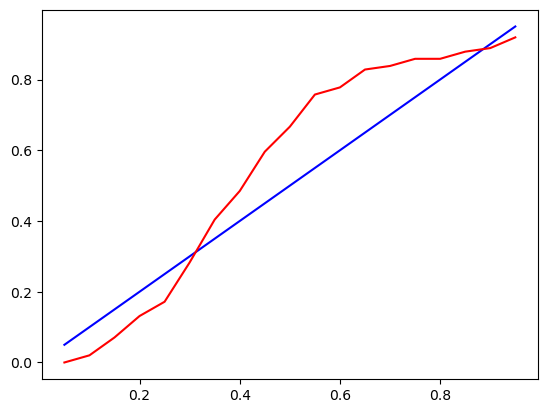

In [490]:
fig, ax = plt.subplots()
ax.plot(reliability[:, 0], reliability[:, 0], 'b')
ax.plot(reliability[:, 0], reliability[:, 1], 'r')